In [89]:
import pandas as pd
from sklearn.linear_model import  LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
import random
import numpy as np

In [90]:
def dataset_to_Xandy(dataset, target_variable):
    X = dataset.loc[:, dataset.columns != target_variable]
    y = dataset.loc[:, dataset.columns == target_variable]
    return X, y

def standardise(X):
    return (X - np.mean(X)) / np.std(X)

def split_dataset(X,y, randomlist, not_in_randomlist):
    X_train = X.iloc[randomlist,:]
    y_train = y.iloc[randomlist,:]
    X_test = X.iloc[not_in_randomlist,:]
    y_test = y.iloc[not_in_randomlist,:]
    return X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy()

def plot_conf_matrix(confusion_matrix,encoding):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.title('Confusion matrix for '+str(encoding)+' encoding')
    plt.show()  

def calc_conf_matrix(X,y,randomlist,not_in_randomlist,classifier, X_binned = None):
    X_train, y_train, X_test, y_test = split_dataset(X,y,randomlist, not_in_randomlist)
        
    
    # depending on what the user inputs
    if classifier == 'logistic':
        model = LogisticRegression(penalty = None)  
    elif classifier == 'kNN':
        model = KNeighborsClassifier()  
    elif classifier == 'decision_tree':
        model = DecisionTreeClassifier()
    else:
        assert('Classifier unknown')
    
    # perform fitting of the model 
    model.fit(X_train, y_train.reshape(-1,))  
    
    if X_binned is not None:
        _,_, X_test_b, _ = split_dataset(X_binned,y,randomlist, not_in_randomlist)
        y_predicted = model.predict(X_test_b) 
    else:
        y_predicted = model.predict(X_test) 
        
    
    # computing confusion matrix, fpr, tpr, auc
    matrix = metrics.confusion_matrix(y_test, y_predicted)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_predicted)
    area_roc = metrics.auc(fpr, tpr)
    return matrix[0,0], matrix[0,1], matrix[1,0], matrix[1,1], area_roc

def plot_boxplots_confusion(confusion_matrix,entry,which_dataset,classifier, how_to_bin, nr_bins):
    dictionary = {}
    for key in confusion_matrix:
        dictionary[key] = confusion_matrix[key][entry]
    fig, ax = plt.subplots()
    ax.boxplot(dictionary.values())
    ax.set_xticklabels(dictionary.keys())
    if entry == '00':
        name = 'true negative'
    elif entry == '01':
        name = 'false positive'
    elif entry == '10':
        name = 'false negative'
    elif entry == '11':
        name = 'true positive'
    elif entry == 'accuracy':
        name = 'accuracy'
    elif entry == 'auc':
        name = 'area under ROC curve'
    plt.title('Boxplots of ' + name +' \n Test Size '+ str(out_of)+'\n Dataset:'+which_dataset+'\n Classifier:'+classifier+'\n Binning:'+str(how_to_bin)+', h = '+str(nr_bins))
    plt.show()    
    

def put_in_bins(data, how_many_bins, how_to_bin):
    mi = min(data)
    ma = max(data)
    if how_to_bin =='cons_std':
        bin_size = how_many_bins * np.std(data)
        start = (mi + ma)/2

        bins_right = [start]
        current_right = 1.0 * start
        while current_right  < ma:
            current_right += bin_size
            bins_right.append(current_right)

        bins_left = []
        current_left = 1.0 * start
        while current_left  > mi:
            current_left -= bin_size
            bins_left.append(current_left)

        bins = np.concatenate((bins_left[::-1],bins_right))
    elif how_to_bin =='fixed_number':
        bins = np.linspace(mi-0.00000001, ma+0.00000001,how_many_bins)
    else:
        assert('Way of binning unknown')
    digitized = np.digitize(data,bins)
    midpoints_bins = (bins[:len(bins)-1] + bins[1:])/2
    new_data = midpoints_bins[digitized-1]
    return new_data
 
def pick_only_some(df, target_variable, number):
    df0 = df.loc[df[target_variable] ==0 ]
    df1 = df.loc[df[target_variable] ==1 ]
    how_many_0 = df0.shape[0]
    how_many_1 = df1.shape[0]
    random_indices = random.sample(range(0, how_many_0), how_many_0 - number)
    df0 = df0.drop(df0.index[random_indices])
    random_indices = random.sample(range(0, how_many_1), how_many_1 - number)
    df1 = df1.drop(df1.index[random_indices])
    df = pd.concat([df0, df1])
    return df

def generating_test_data(how_many_times_repeat, iterations, mu1, sigma1, mu2, 
                         sigma2, plot_classes = False):

    dim = len(mu1)
    testing_data=[]
    belonging_classes=[]

    for repeat in range(how_many_times_repeat):

        random_simulation = np.zeros((iterations,dim))
        which_class_list = np.zeros((iterations,))
        
        for itera in range(iterations):

            which_normal = random.randint(0,1)
            if dim == 1:
                if which_normal == 0:
                    random_simulation[itera,] = np.random.normal(mu1, sigma1)
                else:
                    random_simulation[itera,] = np.random.normal(mu2, sigma2)
            else:
                if which_normal == 0:
                    random_simulation[itera,] = np.random.multivariate_normal(mu1, sigma1)
                else:
                    random_simulation[itera,] = np.random.multivariate_normal(mu2, sigma2)
            which_class_list[itera,] = which_normal
        
        testing_data.append(random_simulation)
        belonging_classes.append(which_class_list)
      
    
    return testing_data, belonging_classes

In [91]:
# which_dataset = 'Simulated Dataset'

# # e1 = [0,0]
# # e2 = [1,1]
# # std1 = np.array(([1,0],[0,1]))
# # std2 = np.array(([1,0],[0,1]))
# # how_many_rows = 100

# # testing_data, belonging_classes = generating_test_data(1, how_many_rows, e1, std1,e2, std2)
# # d = {'feature1':testing_data[0][:,0], 'feature2':testing_data[0][:,1],'target':belonging_classes[0]}
# # df = pd.DataFrame(data=d)

# # df.to_csv('simulated_dataset.csv', index=False)

# df = pd.read_csv('simulated_dataset.csv')

# continuous_variables=['feature1', 'feature2']
# target_variable = 'target'
# categorical_variables = []
# df.head()



In [92]:
########## IRIS FLOWERS DATASET

# which_dataset = 'Iris Flowers'
# df = pd.read_csv('iris.data',header=None)

# continuous_variables = [0,1,2]
# categorical_variables = []
# target_variable = 4
# print(df[target_variable].value_counts()) 

# df = df[ (df[target_variable] == 'Iris-setosa') | (df[target_variable] == 'Iris-versicolor')]
# df[target_variable] = df[target_variable].replace(['Iris-setosa', 'Iris-versicolor'], [0, 1])
# df.drop(columns = [3],inplace=True)
# df

In [93]:
########## BANKNOTES AUTHENTIFICATION DATASET

# which_dataset = 'Banknotes'
# df = pd.read_csv('banknotes.txt',header=None)

# continuous_variables = [0,1,2,3]
# categorical_variables = []
# target_variable = 4
# print(df[target_variable].value_counts()) 
# df

In [94]:
######### AIRLINE DATASET  

# df = pd.read_csv('datasets/airline_dataset.csv')
# categorical_variables = ['MONTH','DAY_OF_WEEK','DEP_TIME_BLK','DISTANCE_GROUP','SEGMENT_NUMBER','CARRIER_NAME', 'DEPARTING_AIRPORT','PREVIOUS_AIRPORT'] # Putting in this all the categorical columns
# target_variable = 'DEP_DEL15' # Making sure the name of the target variable is known

# df0 = df.loc[df[target_variable] ==0 ]
# df1 = df.loc[df[target_variable] ==1 ]
# how_many_0 = df0.shape[0]
# how_many_1 = df1.shape[0]
# random_indices = random.sample(range(0, how_many_0), how_many_0 - 4000)
# df0 = df0.drop(df0.index[random_indices])
# random_indices = random.sample(range(0, how_many_1), how_many_1 - 4000)
# df1 = df1.drop(df1.index[random_indices])
# df = pd.concat([df0, df1])

In [95]:
######## ROCK/MINE DATASET  

# which_dataset = 'Rocks vs Mines'
# df = pd.read_csv('sonar.all-data',header=None)
# df.head()
# continuous_variables = []
# categorical_variables = []
# for i in range(0,60):
#     continuous_variables.append(i)
# target_variable = 60
# df[target_variable] = df[target_variable].replace(['R', 'M'], [0, 1])
# df

In [96]:
########### WINE QUALITY
# df = pd.read_csv('wine_dataset.csv')
# target_variable = 'quality' # Making sure the name of the target variable is known
# df[target_variable] = df[target_variable].replace(['bad'], 0)
# df[target_variable] = df[target_variable].replace(['good'], 1)

# which_dataset = 'Wine Quality'

# categorical_variables = [] # Putting in this all the categorical columns
# continuous_variables = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
#        'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
#        'pH', 'sulphates', 'alcohol']


In [97]:
# ########### BODY SIGNAL SMOKING


# which_dataset = 'Body Signals for Smoking'
# df = pd.read_csv('datasets/bodysignal_smoking.csv')
# df = df.drop(['ID','oral'],axis = 1)

# categorical_variables = [] # Putting in this all the categorical columns
# target_variable = 'smoking' # Making sure the name of the target variable is known

# binary_cols = ['tartar','dental caries','hearing(right)','hearing(left)','gender']
# continuous_variables = list(set(df.keys()) - set(categorical_variables + binary_cols + [target_variable]))
# ### make sure binary variables are 0 and 1
# labelencoder = ce.OrdinalEncoder(cols=binary_cols)
# df = labelencoder.fit_transform(df)

In [98]:
# ###### CROP DATASET


#which_dataset = 'Crop'
# df = pd.read_csv('datasets/crop_dataset.txt')
# target_variable = 'label'
# continuous_variables = list(set(df.keys()) - set([target_variable]))
# categorical_variables = []

# df = df[ (df['label'] == 1) | (df['label'] == 5)]
# df[df['label'] == 5 ] = 0 #### 0 means oats, 1 means corn

# df = pick_only_some(df, target_variable, 4000)
# df = df.reset_index(drop=True)

In [99]:
which_dataset = 'Ionosphere'
df = pd.read_csv('ionosphere.data',header=None)
df.head()
continuous_variables = []
categorical_variables = []
for i in range(0,34):
    if i != 1:
        continuous_variables.append(i)
target_variable = 34
df[target_variable] = df[target_variable].replace(['b', 'g'], [0, 1])
df.drop(columns = [1],inplace=True)
df

,0,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,1,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,0.89391,...,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,1
347,1,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,0.96510,...,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,1
348,1,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,0.94124,...,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,1
349,1,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,0.89724,...,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,1


In [100]:
X, y = dataset_to_Xandy(df, target_variable)
from pingouin import multivariate_normality
multivariate_normality(X,0.1)

HZResults(hz=11.187534303982961, pval=0.0, normal=False)

In [101]:
classifier = 'logistic' 
how_to_bin = 'fixed_number'
nr_bins = 100

In [102]:
categ = len(categorical_variables)
cont = len(continuous_variables)

In [103]:
###### START - PREPROCESSING

size = df.shape[0] # size of the dataset

# Seeing if they are indeed categorical
if categ == 0:
    print('No Categorical Variables')

No Categorical Variables


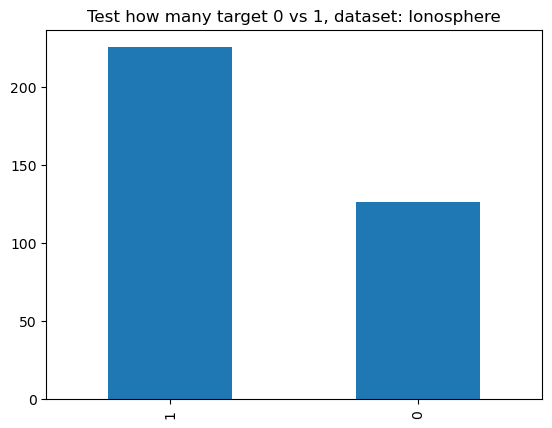

In [104]:
# Seeing if the data is balanced
plt.figure()
df[target_variable].value_counts().plot(kind='bar')
plt.title('Test how many target 0 vs 1, dataset: '+ which_dataset)
plt.show()

In [105]:
df.head()

,0,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,1,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1


In [106]:
# If all columns are continuous, we bin them columns
binned_df = df.copy()
for col in continuous_variables:
    if how_to_bin =='fixed_number':
        binned_df[col] = standardise(put_in_bins(df[col], nr_bins, how_to_bin))
    elif how_to_bin =='cons_std':
        binned_df[col] = standardise(put_in_bins(df[col], nr_bins, how_to_bin))
binned_df.head()

,0,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,0.348433,0.710426,-0.239090,0.484087,-0.208876,0.572588,-0.972198,0.952225,-0.292964,0.668232,...,-0.859912,-0.264804,-0.724487,-0.272372,-0.626424,0.128109,-1.062665,-0.319526,-0.985782,1
1,0.348433,0.710426,-0.516057,0.640727,-1.048533,-1.328112,-2.026860,0.952225,-0.461056,0.054984,...,-0.380183,-1.447830,-0.206047,-0.978967,-0.185633,-0.904368,-0.111348,-0.941953,-0.073859,0
2,0.348433,0.710426,-0.192929,0.758206,-0.253068,0.903145,-0.464398,0.751582,-0.334987,0.451792,...,-0.660025,0.090103,-0.280110,0.080926,-0.305849,0.448533,-0.468092,0.419606,-0.855508,1
3,0.348433,0.710426,-1.116150,0.758206,1.912364,0.324671,-2.144045,-1.014076,-0.377010,-0.846853,...,1.938503,-0.028199,1.941777,1.070160,-0.345921,-0.156713,1.949837,-1.292068,2.097386,0
4,0.348433,0.710426,-0.146768,0.679886,-0.120491,0.779186,-0.698768,0.510811,-0.713194,0.091057,...,-1.139753,-0.777449,-0.835581,-0.625669,-1.187432,-0.726355,-1.141941,-0.747445,-1.463456,1


In [107]:
# We standardise original dataset
for cont_col in continuous_variables:
    df[cont_col] = standardise(df[cont_col])
df.head()

,0,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,0.348433,0.712372,-0.234257,0.484208,-0.201735,0.577059,-0.954679,0.964074,-0.297510,0.668655,...,-0.867565,-0.253868,-0.713971,-0.288290,-0.617039,0.122937,-1.055054,-0.312221,-0.999595,1
1,0.348433,0.721648,-0.527811,0.634308,-1.037587,-1.339106,-2.029452,0.964074,-0.469482,0.057860,...,-0.383054,-1.447849,-0.208419,-0.989185,-0.173530,-0.909063,-0.115213,-0.932605,-0.083286,0
2,0.348433,0.721648,-0.176998,0.768477,-0.241309,0.914531,-0.461494,0.746139,-0.350536,0.452533,...,-0.651896,0.093506,-0.276586,0.091389,-0.287320,0.441318,-0.464092,0.404443,-0.848591,1
3,0.348433,0.721648,-1.125172,0.768477,1.921340,0.329433,-2.152585,-1.010873,-0.375331,-0.846256,...,1.926340,-0.049490,1.947300,1.080843,-0.341218,-0.167687,1.957315,-1.289826,2.107299,0
4,0.348433,0.721648,-0.155129,0.655594,-0.109918,0.754068,-0.676741,0.512838,-0.714742,0.092053,...,-1.143025,-0.792950,-0.842112,-0.615818,-1.171144,-0.717726,-1.154227,-0.757673,-1.435736,1


In [108]:
X, y =  dataset_to_Xandy(df, target_variable) ###### the original dataset
X_bin, y_bin =  dataset_to_Xandy(binned_df, target_variable) ###### the binned dataset

##### the simple encoded dataset (after binned)
labelencoder = ce.OrdinalEncoder(cols=continuous_variables)
simple_df = labelencoder.fit_transform(binned_df)
X_simple,y_simple =  dataset_to_Xandy(simple_df, target_variable) 

##### the one hot encoded dataset (after binned)
encoder = ce.OneHotEncoder(cols=continuous_variables,use_cat_names=True)
onehot_df = encoder.fit_transform(binned_df)
X_onehot,y_onehot =  dataset_to_Xandy(onehot_df, target_variable)

##### the effect encoded dataset (after binned)
encoder = ce.sum_coding.SumEncoder(cols=continuous_variables,verbose=False)
effect_df = encoder.fit_transform(binned_df)
X_effect,y_effect =  dataset_to_Xandy(effect_df, target_variable)


##### the target encoded dataset (after binned)
TE_encoder = ce.TargetEncoder(cols=continuous_variables)
target_df = TE_encoder.fit_transform(binned_df, binned_df[target_variable])
X_target,y_target =  dataset_to_Xandy(target_df, target_variable)

/home/ir318/anaconda3/lib/python3.9/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/home/ir318/anaconda3/lib/python3.9/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


In [109]:
table_unique_elements = [['Name_col','unique_unbinned','unique_binned','unique_target']]
for col in continuous_variables:
    table_unique_elements.append([col,X[col].nunique(),X_bin[col].nunique(),X_target[col].nunique()])

from tabulate import tabulate
print(tabulate(table_unique_elements))

--------  ---------------  -------------  -------------
Name_col  unique_unbinned  unique_binned  unique_target
0         2                2              2
2         219              53             25
3         269              60             30
4         204              53             22
5         259              66             25
6         231              63             24
7         260              75             26
8         244              69             28
9         267              69             28
10        246              76             24
11        269              75             22
12        238              77             27
13        266              78             27
14        234              81             22
15        270              77             26
16        254              81             28
17        280              85             27
18        254              82             24
19        266              81             26
20        248              86     

In [110]:
how_many_iterations = 100 # how many CV folds

# initialising confusion matrices

confusion_matrix = {}
confusion_matrix['not binned'] =  {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['bin_test'] =  {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['binned'] =  {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
# confusion_matrix['simple'] =   {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
#                                'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['onehot'] =  {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['target'] =   {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['effect'] =  {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}

out_of = size - 4 * size // 5

In [111]:
for iteration in range(how_many_iterations):
    
    # Randomising the CV fold
    randomlist = random.sample(range(0, size),  4 * size// 5)
    not_in_randomlist = list(set(range(0,size)) - set(randomlist))
 
    
    ### PREDICTION CONT COLUMNS ARE NOT BINNED
    m0, m1, m2, m3, auc = calc_conf_matrix(X,y,randomlist,not_in_randomlist, classifier, X_binned = None)
    confusion_matrix['not binned']['00'][iteration] = m0
    confusion_matrix['not binned']['01'][iteration] = m1
    confusion_matrix['not binned']['10'][iteration] = m2
    confusion_matrix['not binned']['11'][iteration] = m3
    confusion_matrix['not binned']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['not binned']['auc'][iteration] = auc
    
    
    
    ### PREDICTION CONT COLUMNS ARE BINNED
    m0, m1, m2, m3, auc = calc_conf_matrix(X_bin,y_bin,randomlist,not_in_randomlist, classifier, X_binned = None)
    confusion_matrix['binned']['00'][iteration] = m0
    confusion_matrix['binned']['01'][iteration] = m1
    confusion_matrix['binned']['10'][iteration] = m2
    confusion_matrix['binned']['11'][iteration] = m3
    confusion_matrix['binned']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['binned']['auc'][iteration] = auc
    
    
    
    
    ### PREDICTION CONT COLUMNS ARE NOT BINNED, BUT THE TEST IS ON BINNED DATA
    m0, m1, m2, m3, auc = calc_conf_matrix(X,y,randomlist,not_in_randomlist, classifier, X_binned = X_bin)
    confusion_matrix['bin_test']['00'][iteration] = m0
    confusion_matrix['bin_test']['01'][iteration] = m1
    confusion_matrix['bin_test']['10'][iteration] = m2
    confusion_matrix['bin_test']['11'][iteration] = m3
    confusion_matrix['bin_test']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['bin_test']['auc'][iteration] = auc
    
    
    
    
#     ### PREDICTION CONT COLUMNS ARE BINNED + SIMPLE ENCODING   
#     m0, m1, m2, m3, auc = calc_conf_matrix(X_simple,y_simple,randomlist,not_in_randomlist, classifier, X_binned = None)
#     confusion_matrix['simple']['00'][iteration] = m0
#     confusion_matrix['simple']['01'][iteration] = m1
#     confusion_matrix['simple']['10'][iteration] = m2
#     confusion_matrix['simple']['11'][iteration] = m3
#     confusion_matrix['simple']['accuracy'][iteration] = (m0+m3) / out_of
#     confusion_matrix['simple']['auc'][iteration] = auc
  
    
    
    ### PREDICTION CONT COLUMNS ARE BINNED + ONE HOT ENCODING
    m0, m1, m2, m3, auc = calc_conf_matrix(X_onehot,y_onehot,randomlist,not_in_randomlist, classifier, X_binned = None)
    confusion_matrix['onehot']['00'][iteration] = m0
    confusion_matrix['onehot']['01'][iteration] = m1
    confusion_matrix['onehot']['10'][iteration] = m2
    confusion_matrix['onehot']['11'][iteration] = m3
    confusion_matrix['onehot']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['onehot']['auc'][iteration] = auc
    
    
    
    #### PREDICTION CONT COLUMNS ARE BINNED + EFFECT ENCODING
    m0, m1, m2, m3, auc = calc_conf_matrix(X_effect,y_effect,randomlist,not_in_randomlist, classifier, X_binned = None)
    confusion_matrix['effect']['00'][iteration] = m0
    confusion_matrix['effect']['01'][iteration] = m1
    confusion_matrix['effect']['10'][iteration] = m2
    confusion_matrix['effect']['11'][iteration] = m3
    confusion_matrix['effect']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['effect']['auc'][iteration] = auc
    
    
    
    ##### PREDICTION CONT COLUMNS ARE BINNED + TARGET ENCODING
    m0, m1, m2, m3, auc = calc_conf_matrix(X_target,y_target,randomlist,not_in_randomlist, classifier, X_binned = None)
    confusion_matrix['target']['00'][iteration] = m0
    confusion_matrix['target']['01'][iteration] = m1
    confusion_matrix['target']['10'][iteration] = m2
    confusion_matrix['target']['11'][iteration] = m3
    confusion_matrix['target']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['target']['auc'][iteration] = auc

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ir318/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

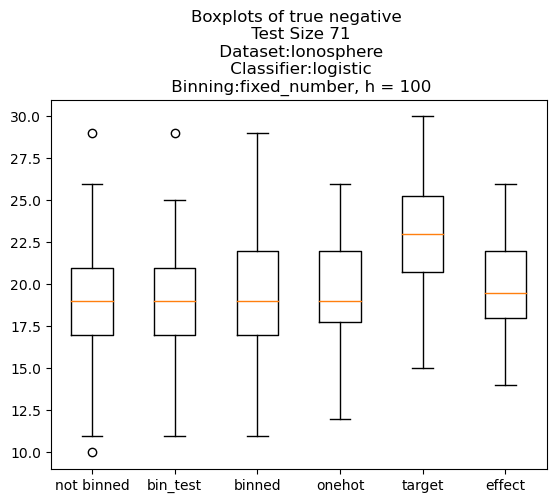

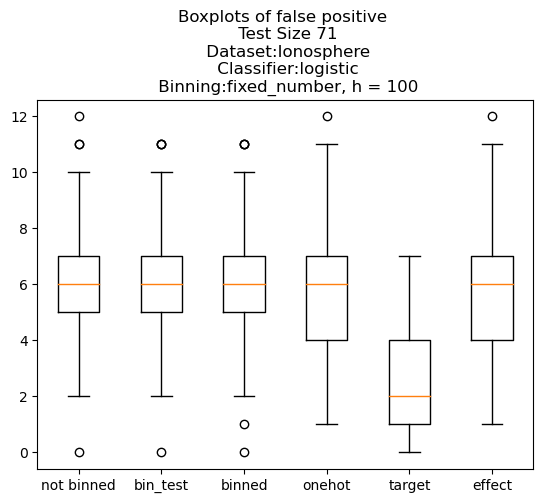

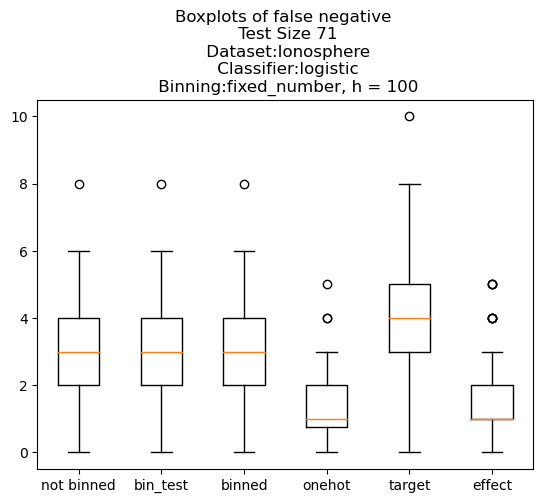

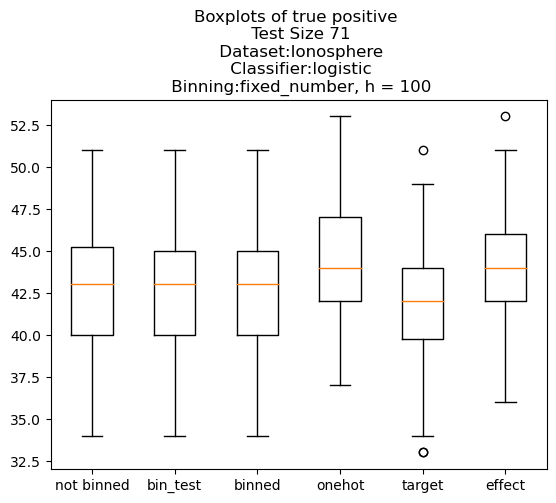

In [112]:
plot_boxplots_confusion(confusion_matrix, '00', which_dataset, classifier, how_to_bin, nr_bins)
plot_boxplots_confusion(confusion_matrix, '01', which_dataset, classifier, how_to_bin, nr_bins)
plot_boxplots_confusion(confusion_matrix, '10', which_dataset, classifier, how_to_bin, nr_bins)
plot_boxplots_confusion(confusion_matrix, '11', which_dataset, classifier, how_to_bin, nr_bins)

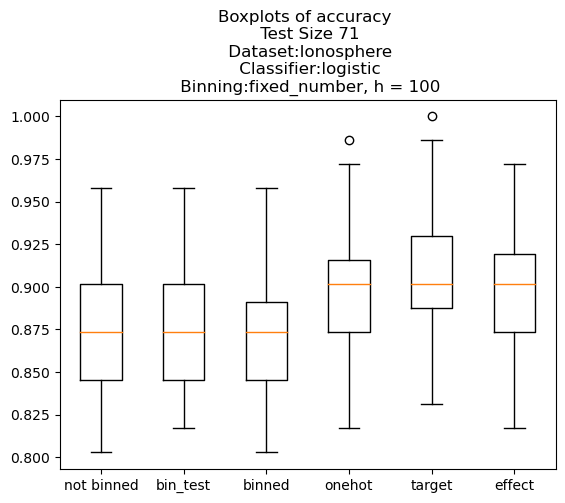

In [113]:
plot_boxplots_confusion(confusion_matrix, 'accuracy', which_dataset, classifier, how_to_bin, nr_bins)

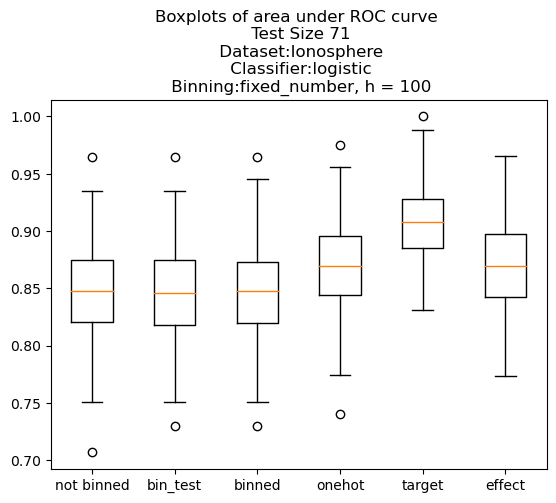

In [114]:
plot_boxplots_confusion(confusion_matrix, 'auc', which_dataset, classifier, how_to_bin, nr_bins)